<a href="https://colab.research.google.com/github/dtabuena/Images/blob/main/Crisper_Immuno/RNF182_Image_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install python-bioformats
import javabridge
import bioformats
javabridge.start_vm(class_path=bioformats.JARS)

####
from IPython.display import clear_output

import numpy as np
import pandas as pd
import skimage
from skimage import filters
from matplotlib import pyplot as plt
import matplotlib
import os
import scipy
from scipy import ndimage as ndi
import os
import tifffile
from tqdm import tqdm
from google.colab import files

os.environ["CELLPOSE_LOCAL_MODELS_PATH"] = "/PATH_FOR_MODELS/"

!pip install cellpose
from cellpose import models
clear_output()

In [2]:
def get_drobox_folder(link, new_filename):
    'Download a folder from dropbox and unzip'
    zipped_file_path = "/content/"+new_filename + ".zip"
    unzipped_file_path = "/content/"+new_filename
    if not( os.path.exists(zipped_file_path)):
        !wget -O $zipped_file_path $link    # download with new name
    !echo A | unzip $zipped_file_path -d $unzipped_file_path 
    return new_filename

def get_sub_files(rootdir):
    'Recursively search subfolders and return a list of all files'
    file_list =[]
    for rootdir, dirs, files in os.walk(rootdir): 
            file_list.extend([os.path.join(rootdir,f) for f in files])
    return file_list

def read_image(image_name):
    my_reader = bioformats.get_image_reader('my_image', image_name)

    c_dim = my_reader.rdr.getSizeC()
    z_dim = my_reader.rdr.getSizeZ()
    x_dim = my_reader.rdr.getSizeX()
    y_dim = my_reader.rdr.getSizeY()
    # print(x_dim,y_dim,c_dim,z_dim)

    image = np.empty([x_dim,y_dim,c_dim,z_dim])
    for zi in range(z_dim):
        img_zi = my_reader.read(c=None, z=zi,rescale=True)
        image[:,:,:,zi] = img_zi

    for ci in range(image.shape[2]):
        cim = image[:,:,ci,:]
        flat = cim.flatten()
        max= np.percentile(flat,100)
        assert max>0 , print(flat)
        cim = cim/max
        image[:,:,ci,:] = cim
    return image


def norm_channels(image,chan_dim,z_dim,):
    '''Transpose ndims, preserve labels'''
    dim_order = np.arange(image.ndim).tolist()
    dim_order = [chan_dim, z_dim] + [d for d in dim_order if d not in [chan_dim, z_dim]]
    chan_dim = [i for i in range(len(dim_order)) if dim_order[i]==chan_dim][0]
    z_dim = [i for i in range(len(dim_order)) if dim_order[i]==z_dim][0]

    '''Normalize channel intensities'''
    image_r=np.transpose(image.copy(),dim_order)
    ch_val_list = []
    for ch in range(image_r.shape[chan_dim]):    
        ch_val = image_r[ch,:,:,:].copy()
        for zi in range(image_r.shape[z_dim]):
            ch_val_z = ch_val[zi,:,:]
            ch_val_z = (ch_val_z-np.mean(ch_val_z.flatten())) / np.std(ch_val_z.flatten()) # zscore
            ch_val_z = (ch_val_z) / np.std(ch_val_z.flatten())
            ch_val[zi,:,:] = ch_val_z
        ch_val_list.append(ch_val)
    image_znorm = np.stack(ch_val_list,axis=0)
    return image_znorm, image_r,chan_dim,z_dim


def mask_image_cellpose(image_r,cell_chan,diameter,exp_dist):
    '''Generate Masks with Cellpose'''
    model = models.Cellpose(model_type='cyto')
    masks, _, _, _ = model.eval(image_r[cell_chan,:,:,:], diameter=diameter, channels=[0,0], stitch_threshold=.001,do_3D=False)
    masks=masks.astype(float)
    exp_masks = masks.copy()
    for zi in range(masks.shape[0]):
        exp_masks[zi,:,:] = skimage.segmentation.expand_labels(exp_masks[zi,:,:], distance=exp_dist)
    return exp_masks, exp_masks



def quant_cells(image_znorm, image_r, exp_masks,chan_dim):
    '''Quantify Cell Intensities'''
    cell_ids =np.arange(0,np.nanmax(exp_masks.flatten()))+1
    cell_df = pd.DataFrame({'cell_id':cell_ids}).set_index('cell_id')
    for ch in range(image_znorm.shape[chan_dim]):
        for cell in cell_df.index:
            if ch==0:
                cell_df.at[cell,'size'] = np.nansum((exp_masks.flatten()==cell))
                cell_df.at[cell,'cross_area'] = np.nansum( np.max( exp_masks==cell,axis=0).flatten())
                cell_coord = np.where(exp_masks==cell)
                image_size = exp_masks.shape
                dim_check =[]
                for di in range(len(cell_coord)):
                    dim_check.append(0 == min(cell_coord[di]))
                    dim_check.append(np.max(cell_coord[di]) == image_size[di])
                cell_df.at[cell,'is_edge'] = any(dim_check)

            cell_df.at[cell,'mean_'+ch_names[ch]] = np.nansum( image_znorm[ch,:,:,:][exp_masks==cell]) / cell_df.loc[cell,'size']
            cell_df.at[cell,'raw_mean_'+ch_names[ch]] = np.nansum( image_r[ch,:,:,:][exp_masks==cell]) / cell_df.loc[cell,'size']
            
    return cell_df


def calc_odd(cell_df,t):
    '''Calculate Odds Ratios'''
    is_green = cell_df['mean_target']>t
    not_green = cell_df['mean_target']<=t
    is_red = cell_df['mean_mCherry']>t
    not_red = cell_df['mean_mCherry']<=t

    p_G_nR = np.mean(  is_green[not_red]  )
    p_G_iR = np.mean(  is_green[is_red]  )
    # print('P(G|~R)',p_G_nR)
    # print('P(G|R)',p_G_iR)

    p_R_iG = np.mean(  is_red[is_green]  )
    p_R_nG = np.mean(  is_red[not_green]  )
    # print('P(R|G)',p_R_iG)
    # print('P(R|~G)',p_R_nG)

    num_RnG = np.sum(is_red[not_green] )
    num_nRnG = np.sum(not_red[not_green] )
    num_RG = np.sum(is_red[is_green] )
    num_nRG = np.sum(not_red[is_green] )
    OR = (num_RG * num_nRnG)/ (num_RnG * num_nRG)
    # print('odds',OR)

    targ_sig_nR = np.mean(cell_df['raw_mean_target'][cell_df['mean_mCherry']<t])
    targ_sig_iR = np.mean(cell_df['raw_mean_target'][cell_df['mean_mCherry']>t])

    results = {'OR':OR,
               'num_RnG':num_RnG,
               'num_nRnG':num_nRnG,
               'num_RG':num_RG,
               'num_nRG':num_nRG,
               'targ_sig_nR':targ_sig_nR,
               'targ_sig_iR':targ_sig_iR}

    cell_df['Pos']=cell_df['mean_mCherry']>t
    mean_target_negative = np.mean(cell_df['raw_mean_target'][np.logical_not(cell_df['Pos'].values)])
    mean_target_negative=1
    cell_df['target_norm'] = cell_df['raw_mean_target'] / mean_target_negative
    cell_df['target_norm_NEG'] = cell_df['target_norm'][np.logical_not(cell_df['Pos'].values)]
    cell_df['target_norm_POS'] = cell_df['target_norm'][cell_df['Pos']]

    cell_df['cross_area_NEG'] = cell_df['cross_area'][np.logical_not(cell_df['Pos'].values)]
    cell_df['cross_area_POS'] = cell_df['cross_area'][cell_df['Pos']]

    results=pd.DataFrame(data=results,index=[0])


    return results, cell_df



def plot_sample(fov,inset_xy=None,pxl_per_um=800/159.1,title=None,zi=0,mask=None,min=0,max=4,zmax=False):
    sb_x = 195
    sb_y = 4
    sb_x = 780
    sb_y = 10

    plot_norm = fov['image_znorm'].copy()

    if zmax:
        plot_norm[:,0,:,:] = np.nanmax(plot_norm,axis=1)
        if mask is not None: mask[0,:,:] = np.max(mask,axis=0)
        zi=0

    for ch in range(plot_norm.shape[0]):
        plot_norm[ch,:,:,:] = (np.clip(plot_norm[ch,:,:,:],min,max)-min)/(max-min)
        # plt.hist(plot_norm.flatten(),np.arange(min,max,.1))



    image_name= fov['image_name']
    image_name= os.path.basename(fov['image_name']).split('.')[0]
    potential_targets = ['MDGA2','Nell2','RNF182']
    target_name = [t for t in potential_targets if t in image_name][0]
    # print(target_name)

    if inset_xy is not None: fig_sample, axs = plt.subplots(2,4,figsize=(20,10))
    else: fig_sample, axs = plt.subplots(1,4,figsize=(20,5))
    
    axs=axs.flatten()
    axs[0].imshow(plot_norm[2,zi,:,:],cmap='gray') # ,vmax=1.5
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
    axs[1].imshow(plot_norm[1,zi,:,:],cmap=cmap) # ,vmax=1.5
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
    axs[2].imshow(plot_norm[0,zi,:,:],cmap=cmap) # ,vmax=1.5


    w_sig = plot_norm[2,zi,:,:]
    # w_sig = w_sig+np.percentile(w_sig.flatten(),.1)
    # w_sig = w_sig/np.percentile(w_sig.flatten(),99.9)
    w_chan = np.stack( [w_sig for i in range(3)] ,axis=-1)
    r_sig = plot_norm[1,zi,:,:]
    # r_sig = r_sig+np.percentile(r_sig.flatten(),.0)
    # r_sig = r_sig/np.percentile(r_sig.flatten(),100)
    r_chan = np.stack( [r_sig, np.zeros_like(r_sig), np.zeros_like(r_sig)],axis=-1)
    g_sig = plot_norm[0,zi,:,:]
    # g_sig = g_sig-(np.percentile(g_sig.flatten(),0)*2)
    # g_sig = g_sig/(np.percentile(g_sig.flatten(),100)*1)
    g_chan = np.stack( [ np.zeros_like(g_sig), g_sig, np.zeros_like(g_sig)],axis=-1)
    merge = w_chan*0.3 + r_chan + g_chan*0.5
    axs[3].imshow(merge)


    axs[0].text(10,790,'NeuN',color='w',fontsize=24)
    axs[1].text(10,790,'mCherry',color=[1,0,0,1],fontsize=24)
    axs[2].text(10,790,target_name,color=[0,1,0,1],fontsize=24)
    # axs[3].text(0,800,'NeuN',color='w')

    pxl_per_um = 800/160
    sb_x = merge.shape[1]*.975
    sb_y = merge.shape[0]*.025
    big_scale_bar = matplotlib.patches.Rectangle([sb_x,sb_y],   -25*pxl_per_um , 10, alpha=1, facecolor='w',edgecolor='w',linewidth=0)
    axs[0].add_patch(big_scale_bar)

    if inset_xy is not None:
        y1,y2,x1,x2, = inset_xy
        my_rect = matplotlib.patches.Rectangle([y1,x1],  y2-y1, x2-x1,alpha=1, facecolor='none',edgecolor='c',linewidth=3)
        axs[0].add_patch(my_rect)

        # fig, axs = plt.subplots(1,4,figsize=(32,8))
        # axs=axs.flatten()
        axs[4].imshow(plot_norm[2,zi,x1:x2,y1:y2],cmap='gray',vmax=1)
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
        axs[5].imshow(plot_norm[1,zi,x1:x2,y1:y2],cmap=cmap, vmax=1)
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
        axs[6].imshow(plot_norm[0,zi,x1:x2,y1:y2],cmap=cmap,vmax=1)
        axs[7].imshow(merge[x1:x2,y1:y2,:])

        sb_x = (x2-x1)*.975
        sb_y = (y2-y1)*.025
        small_scale_bar = matplotlib.patches.Rectangle([sb_x,sb_y],   -5*pxl_per_um , 3, alpha=1, facecolor='w',edgecolor='w',linewidth=0)
        axs[4].add_patch(small_scale_bar)


    for a in axs:
            a.get_xaxis().set_visible(False)
            a.get_yaxis().set_visible(False)
        
    if mask is not None:
        mask_bin = mask[zi,:,:]>0
        edge_bin = skimage.filters.sobel(mask[zi,:,:])>0
        print(edge_bin.shape)
        for a in axs[:4]:
            a.contour(edge_bin)
        for a in axs[4:]:
            a.contour(edge_bin[x1:x2,y1:y2])

    if title is not None:
        fig_sample.suptitle(title)
    plt.tight_layout(pad=1.1)
    plt.show()
    fig_sample.savefig(image_name+'MergePlot.png')    
    return None


def load_or_gen_mask(image_r,cell_chan,diameter,exp_dist,file_name,mask_dir=None):
    if mask_dir is not None:
        mask_files = get_sub_files(mask_dir)
        # pot_masks = get_sub_files(mask_dir)
        # pot_masks.sort()
        _ = [print('Found mask: '+ f) for f in mask_files]
    else: mask_files=[]
    mask_file_name = file_name.split('.')[0].split('/')[-1] + '_mask.tiff'
    print(f'searching for {mask_file_name}')

    find_match = [i for i in range(len(mask_files)) if mask_file_name in mask_files[i]]
    if len(find_match)>0:
        prev_mask_filename = mask_files[find_match[0]]
        print(f'load existing mask ({prev_mask_filename})')
        masks = tifffile.imread(prev_mask_filename)
        print('masks.shape',masks.shape)
        masks=masks.astype(float)
        exp_masks = masks.copy()
        for zi in range(masks.shape[0]):
            if exp_dist<0:
                circle = skimage.morphology.disk(abs(exp_dist))
                exp_masks[zi,:,:] = skimage.morphology.erosion(exp_masks[zi,:,:], selem=circle)
            else:
                exp_masks[zi,:,:] = skimage.segmentation.expand_labels(exp_masks[zi,:,:], distance=exp_dist)
    else: 
        print('generate new mask')
        image_r_plusred = image_r.copy()
        # image_r_plusred[2,:,:,] = (image_r_plusred[2,:,:,] + image_r_plusred[1,:,:,])/2
        masks, exp_masks = mask_image_cellpose(image_r_plusred,cell_chan,diameter,exp_dist)
        tifffile.imsave(os.path.join('Image_Masks',mask_file_name),masks)
    return masks, exp_masks



def image_pipeline(image_name,chan_dim,cell_chan,z_dim,mask_dir,t=0,exp_dist = 5,diameter = 30):
    # try:
    image = read_image(image_name)
    my_disk = skimage.morphology.disk(3)
    display(my_disk)
    for zi in range(image.shape[z_dim]):
        for ci in range(image.shape[chan_dim]):
            image[:,:,ci,zi] = skimage.filters.median(image[:,:,ci,zi],selem=my_disk)

    if image.shape[chan_dim]==4:
        image = combine_dapi_neun( image, chan_dim, ch_ind=[0,3], keep_ch=3,scalar = 0 )
    # image=np.sum(image,axis=z_dim)
    # # image = np.percentile(image,80,axis=z_dim)
    # image=np.stack([image,image],axis=z_dim)
    image_znorm, image_r,chan_dim,z_dim = norm_channels(image,chan_dim,z_dim,)
    
    

    # mask_dir = get_drobox_folder('https://www.dropbox.com/sh/9183tn13gv1ixui/AABUOQ5jcp6QzuwjBwdbi3WPa?dl=0', 'Image_Masks')
    clear_output()
    masks, exp_masks = load_or_gen_mask(image_r,cell_chan,diameter,exp_dist,image_name,mask_dir)
    # masks, exp_masks = mask_image_cellpose(image_r,cell_chan,diameter,exp_dist)
    print(masks.shape, 'vs', image_znorm.shape)
    print(str(np.max(exp_masks.flatten())) + ' cells in mask')
    cell_df = quant_cells(image_znorm, image_r, exp_masks,chan_dim)
    print(cell_df.columns)
    results,cell_df = calc_odd(cell_df,t)
    cur_image_name= os.path.basename(image_name).split('.')[0]
    potential_targets = ['MDGA2','Nell2','RNF182']
    target_name = [t for t in potential_targets if t in cur_image_name][0]
    cell_df.to_csv( cur_image_name+'Cell_Stats.csv')

    fov_dict = {'image_name':image_name,
                'raw_image':image,
                'image_r':image_r,
                'image_znorm':image_znorm,
                'masks':masks,
                'exp_masks':exp_masks,
                'cell_df':cell_df,
                'results':results,
                }

    # inset_xy =  [150,350,0,200]
    # plot_sample(fov_dict)
    plot_sample(fov_dict,mask=exp_masks,zmax=True)
    # except: print(image_name)
    
    return fov_dict



In [ ]:
import shutil
if os.path.isdir('/content/Image_Masks'): shutil.rmtree('/content/Image_Masks')
data_drop_folder = 'https://www.dropbox.com/sh/3i0fxy5s5aqdlnx/AABOur-nLFA7ihalA6EDr2wCa?dl=0' # RNF182
mask_dir = get_drobox_folder('https://www.dropbox.com/sh/9183tn13gv1ixui/AABUOQ5jcp6QzuwjBwdbi3WPa?dl=0', 'Image_Masks')
data_folder = get_drobox_folder(data_drop_folder, 'images')
file_list = get_sub_files(data_folder)
file_list.sort()
file_list = [f for f in file_list if 'DAPI' not in f]
file_list = [f for f in file_list if 'NoPos' not in f]
file_list = [f for f in file_list if 'Skip' not in f]
file_list = [f for f in file_list if 'CA' in f]

Found mask: /content/Image_Masks/RNF182_08-17-22_DG_40X_2xzoom_1_mask.tiff
Found mask: /content/Image_Masks/Nell2_08-04-22_S001_DG_40X_2XZoom_1_mask.tiff
Found mask: /content/Image_Masks/RNF182_08-15-22_CA3_40X_2xzoom_1_mask.tiff
Found mask: /content/Image_Masks/RNF182_08-12-22_DG_40X_2xzoom_1_mask.tiff
Found mask: /content/Image_Masks/RNF182_08-15-22_DG_40X_2xzoom_1_mask.tiff
Found mask: /content/Image_Masks/Nell2_08-04-22_S002_DG_40X_2XZoom_1_mask.tiff
Found mask: /content/Image_Masks/Nell2_08-04-22_DG_40X_2XZoom_1_mask.tiff
Found mask: /content/Image_Masks/RNF182_08-17-22_CA3_40X_2xzoom_1_mask.tiff
Found mask: /content/Image_Masks/RNF182_08-16-22_DG_40X_2xzoom_1_mask.tiff
Found mask: /content/Image_Masks/RNF182_08-12-22_CA3_40X_2xzoom_1_mask.tiff
Found mask: /content/Image_Masks/Nell2_08-10-22__S001_DG_40X_2XZoom_2_mask.tiff
Found mask: /content/Image_Masks/RNF182_08-16-22_CA3_40X_2xzoom_1_mask.tiff
searching for RNF182_08-16-22_CA3_40X_2xzoom_1_mask.tiff
load existing mask (/conten

(800, 800)


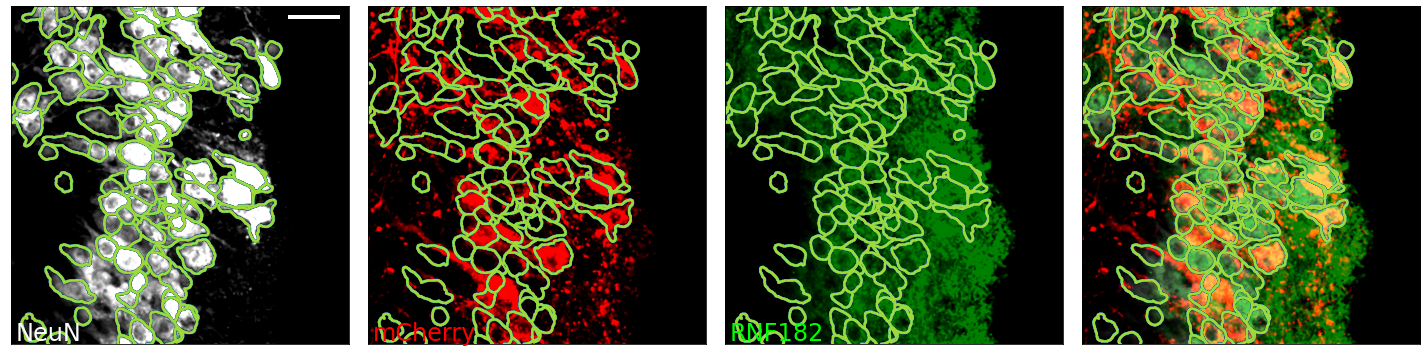

In [4]:
make_new_masks = False

import shutil
if make_new_masks: 
    if os.path.isdir('/content/Image_Masks'): shutil.rmtree('/content/Image_Masks')

exp_dist = 0
chan_dim = 2
cell_chan = 2
z_dim = 3
diameter = 30
min_vox = 500
t = 0
ch_names = ['target','mCherry','NeuN']
mask_dir = '/content/Image_Masks'
try: os.makedirs(mask_dir)
except: None
image_results_list=[]
n=1
for f in file_list[:]:
    try: 
        fov = image_pipeline(f,chan_dim,cell_chan,z_dim,mask_dir,t=1,exp_dist=3,diameter=55) # ,exp_dist=exp_dist
        image_results_list.append(fov)
    except: print ('error on ', f)